In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

from itertools import product
import pandas as pd
import torch
import torch.nn.functional as F
from torch_sparse.tensor import SparseTensor
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

from src.train.gcn_node_classifier import GCNNodeClassifierTrainer
from src.torch_geo_models import GCN
from src.data.node_classifier.arxiv import load_dataset_pyg,\
    data_to_sparse_symmetric_pyg, get_edge_weights_pyg

In [27]:
weights_source = 'structural_omega_graph_sage_cossim'

### Read metrics

In [28]:
metrics = GCNNodeClassifierTrainer.read_metrics(weights_source=weights_source)
print(metrics.shape)
metrics.head()

(2435, 10)


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
0,1,0,False,1,3.699463,3.730673,3.720882,0.010809,0.010537,0.011152
1,1,50,False,1,3.174638,3.246686,3.267643,0.182635,0.082956,0.066045
2,1,100,False,1,2.962414,3.025093,3.061114,0.190398,0.096648,0.076559
3,1,150,False,1,2.824658,2.892854,2.938430,0.255275,0.231350,0.208917
4,1,200,False,1,2.710433,2.789759,2.843210,0.293894,0.298030,0.276135


## Selected model results

For each configuration we select a model based on the validation accuracy and compare on the test nodes.

In [29]:
def get_best_metrics(keys_df: pd.DataFrame):
    return keys_df.sort_values('acc_val', ascending=False).iloc[0]

best_epoch_metrics = metrics\
    .groupby(['run', 'n_layers', 'has_edge_weights'])\
    .apply(get_best_metrics)\
    .reset_index(drop=True)

print(best_epoch_metrics.shape)
print(best_epoch_metrics['run'].max())
best_epoch_metrics.tail()

(25, 10)
5


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
20,4,2200,False,2,0.657163,0.897757,0.933699,0.790271,0.725058,0.714647
21,4,2550,True,2,0.821963,1.094231,1.080312,0.756479,0.694621,0.695780
22,4,1300,False,3,0.610413,0.859170,0.906102,0.799024,0.732575,0.718001
23,4,2000,True,3,0.783433,1.046656,1.059485,0.766211,0.699218,0.700677
24,5,500,False,1,2.231807,2.343123,2.425748,0.466225,0.485654,0.469045


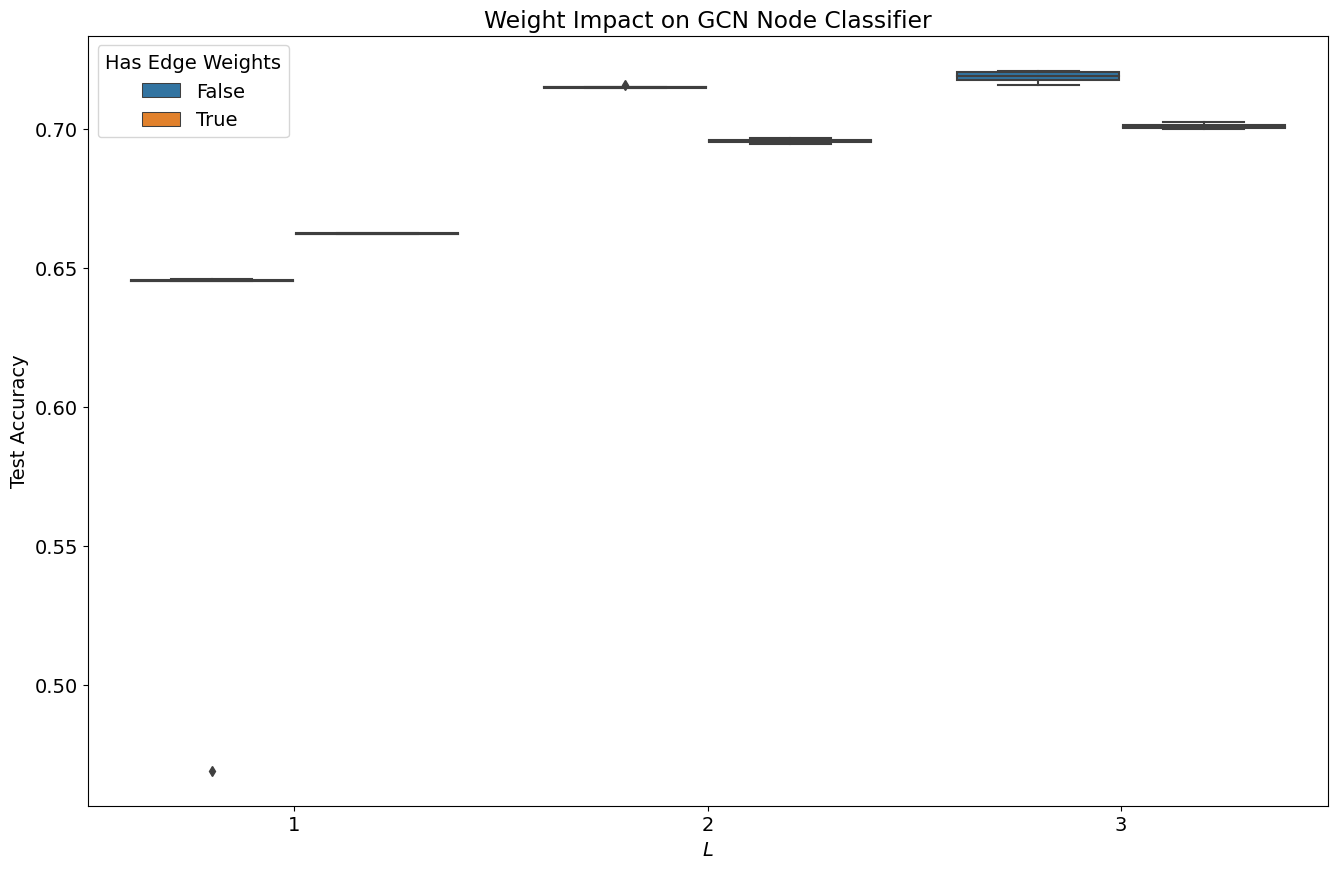

In [30]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

plt.title('Weight Impact on GCN Node Classifier')

sns.boxplot(
    data=best_epoch_metrics,
    x='n_layers',
    y='acc_test',
    hue='has_edge_weights')

plt.ylabel('Test Accuracy')
plt.xlabel('$L$')


# plt.yscale('log')
plt.legend(title='Has Edge Weights')
plt.savefig('reports/images/structural_graph_sage_cossim_weight_impact_gcn_node_classifier.pdf')

## T-test

In [31]:
report = {
    '$L$': [],
    'Weighted': [],
    'Unweighted': [],
    '$t$': [],
    'p-value': []
}

for n_layers in range(1, 4):
    a = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == True')\
        ['acc_test']
        
    b = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == False')\
        ['acc_test']
    ttest = ttest_ind(a, b)
    
    report['$L$'].append(f'${n_layers}$')
    report['Weighted'].append(f'${a.mean():.4} \pm {a.std():.2}$')
    report['Unweighted'].append(f'${b.mean():.4} \pm {b.std():.2}$')
    report['$t$'].append(f'${ttest.statistic:.4}$')
    report['p-value'].append(f'${ttest.pvalue:.4}$')
    
    
    print(f'with: {a.mean():.4} +- {a.std():.2}, '
          f'no: {b.mean():.4} +- {b.std():.4}, '
          f't: {ttest.statistic:.4}, pvalue: {ttest.pvalue:.4}')

with: 0.6624 +- 8.6e-05, no: 0.6103 +- 0.07897, t: 1.301, pvalue: 0.2345
with: 0.6957 +- 0.00093, no: 0.7152 +- 0.0005833, t: -35.35, pvalue: 3.414e-08
with: 0.7011 +- 0.0011, no: 0.7188 +- 0.002265, t: -14.22, pvalue: 7.557e-06


In [32]:
print(pd.DataFrame(report).style.to_latex())

\begin{tabular}{llllll}
 & $L$ & Weighted & Unweighted & $t$ & p-value \\
0 & $1$ & $0.6624 \pm 8.6e-05$ & $0.6103 \pm 0.079$ & $1.301$ & $0.2345$ \\
1 & $2$ & $0.6957 \pm 0.00093$ & $0.7152 \pm 0.00058$ & $-35.35$ & $3.414e-08$ \\
2 & $3$ & $0.7011 \pm 0.0011$ & $0.7188 \pm 0.0023$ & $-14.22$ & $7.557e-06$ \\
\end{tabular}



## Epochs comparison

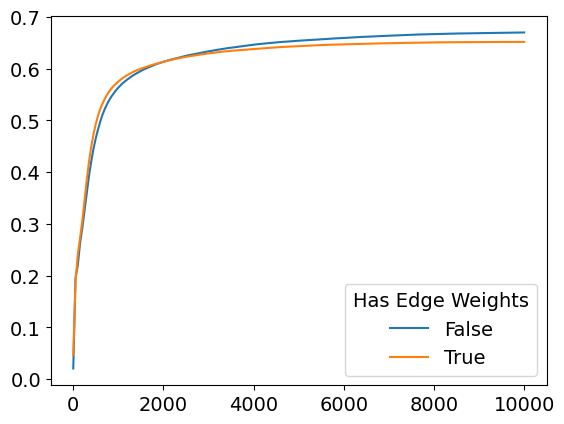

In [33]:
n_layers = 1
col = 'acc_train'

sub_df = metrics.query(f'n_layers == {n_layers}')

no_means = sub_df\
    .query('has_edge_weights == False')\
    .groupby('epoch')\
    [col]\
    .mean()

w_means = sub_df\
    .query('has_edge_weights == True')\
    .groupby('epoch')\
    [col]\
    .mean()

plt.plot(no_means, label='False')
plt.plot(w_means, label='True')

plt.legend(title='Has Edge Weights')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(200)
# plt.ylim(0.65, 0.75)